# Vorhersage von Sportergebnissen mittels probabilistischer Programmierung


In [27]:
import numpy as np
import pandas as pd

import pymc as pm

import scipy

# for plotting
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

%matplotlib inline


# # directed graphical models as pretty figures
# import daft
from collections import OrderedDict


In [2]:
import pandas as pd

tie = 0
p1 = 1
p2 = 2
pp = [tie, p1, p2]

df = pd.DataFrame([pp], columns=["tie", "home", "away"])
print(df)

   tie  home  away
0    0     1     2


In [1]:
import pandas as pd

tie = 0
p1 = 1
p2 = 2
pp = [tie, p1, p2]

pd.DataFrame(pp, columns=["tie", "home", "away"])


ValueError: Shape of passed values is (3, 1), indices imply (3, 3)

In [6]:
import pandas as pd

df_new = pd.DataFrame({"Column1": [1, 2, 3], "Column2": ["A", "B", "C"]})
print(df_new)


t = [(1, 2), (1, 2), (1, 2)]

list(map(lambda x: x[1], t))


   Column1 Column2
0        1       A
1        2       B
2        3       C


[2, 2, 2]

In [ ]:
df_new = df_new[["Column1"]]
print(df_new)
first_column = list(map(lambda x: x[0], t))
print(first_column)


In [3]:
# kwargs dict for histograms
plot_hist_param = {
    "facecolor": "#2ab0ff",
    "edgecolor": "#169acf",
    "linewidth": 0.5,
    "density": True,
}

## Model 1

Funktion zur plotten des einfaches Modells mit der Bibliothek `daft`.

In [4]:
# def plot_model(save=True):
#     pgm = daft.PGM(
#         [7.3, 3.05],
#         grid_unit=2.0,
#         node_unit=1.0,
#         origin=[1.0, 0.0],
#         aspect=1.0,
#         dpi=200,
#     )
#     pgm.add_node(daft.Node("o_i", r"oA", 1.5, 2))
#     pgm.add_node(daft.Node("d_j", r"dB", 1.5, 1))

#     pgm.add_node(daft.Node("o_j", r"oB", 6.5, 1))
#     pgm.add_node(daft.Node("d_i", r"dA", 6.5, 2))

#     # pgm.add_node(daft.Node("Delta", r"$\Delta_{ij}$", 2.5, 1))
#     pgm.add_node(daft.Node("diffAB", r"$\Delta$AB", 2.5, 1.5))
#     pgm.add_node(daft.Node("none_AB", "", 2.5, 1.5, scale=0.85, aspect=1))
#     pgm.add_node(daft.Node("gAB", r"gAB", 3.5, 1.5, observed=True))

#     pgm.add_node(daft.Node("diffBA", r"$\Delta$BA", 5.5, 1.5))
#     pgm.add_node(daft.Node("none_BA", "", 5.5, 1.5, scale=0.85, aspect=1))
#     pgm.add_node(daft.Node("gBA", r"gBA", 4.5, 1.5, observed=True))

#     # Add in the edges.

#     pgm.add_edge("o_i", "diffAB")
#     pgm.add_edge("d_j", "diffAB")
#     pgm.add_edge("diffAB", "gAB")
#     pgm.add_edge("o_j", "diffBA")
#     pgm.add_edge("d_i", "diffBA")
#     pgm.add_edge("diffBA", "gBA")
#     # if save:
#     #    pgm.savefig('pics/figure_6.png')
#     pgm.render()


# plot_model()

### Load Data


Split the data in training and test set at a fixed date.



In [54]:
# load the data from https://www.football-data.co.uk/germanym.php
# and copy it to a file
filepath = "S:/___Studium/Bachelor_Arbeit/ba_env/bundesliga/data/01_raw/football-datasets/D1-24-25.csv"
df = pd.read_csv(filepath, sep=",")
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
d1 = df[:51]
df[51:52]

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA
51,D1,2024-10-06,14:30,Heidenheim,RB Leipzig,0,1,A,0,0,...,2.04,1.89,2.04,1.88,2.04,1.96,1.98,1.88,2.05,1.94


In [55]:
# all teams as numpy arrays
t1 = d1.HomeTeam.unique().astype("U")
t2 = d1.AwayTeam.unique().astype("U")
teams = np.unique(np.concatenate((t1, t2)))

print(teams)
assert len(teams) == 18
nb_teams = len(teams)

['Augsburg' 'Bayern Munich' 'Bochum' 'Dortmund' 'Ein Frankfurt' 'Freiburg'
 'Heidenheim' 'Hoffenheim' 'Holstein Kiel' 'Leverkusen' "M'gladbach"
 'Mainz' 'RB Leipzig' 'St Pauli' 'Stuttgart' 'Union Berlin'
 'Werder Bremen' 'Wolfsburg']


In [56]:
# get data record from team indices
def getResults(homeTeamIndex, awayTeamIndex, df=d1):
    homeTeam = teams[homeTeamIndex]
    awayTeam = teams[awayTeamIndex]
    return df.query("HomeTeam == '" + homeTeam + "' and AwayTeam == '" + awayTeam + "'")


getResults(0, 3)

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA


In [57]:
# build team lexicon
# map from team-index to Name
team_indices = OrderedDict()
for i, t in enumerate(teams):
    team_indices[t] = i

In [58]:
GOALS_HOME = "FTHG"
GOALS_AWAY = "FTAG"


def get_goal_results(d=d1, gh=GOALS_HOME):
    result = list()
    for r in d.iterrows():
        home_team = r[1].HomeTeam
        away_team = r[1].AwayTeam
        goals = r[1][gh]
        result.append((team_indices[home_team], team_indices[away_team], goals))
    return result


home_goals_ = get_goal_results(gh=GOALS_HOME)
away_goals_ = get_goal_results(gh=GOALS_AWAY)

# list of tuples
# (home_team-index, away_team_index, scored_goals of home team resp. away team)
home_goals_[:3]

[(10, 9, 2), (0, 16, 2), (5, 14, 3)]

In [59]:
low = 10e-8  # Constant

In [60]:
def vectorized_data(home_goals_, away_goals_):
    home_id = np.array([hg[0] for hg in home_goals_])
    away_id = np.array([hg[1] for hg in home_goals_])
    home_goals = np.array([hg[2] for hg in home_goals_])
    away_goals = np.array([ag[2] for ag in away_goals_])
    toto = np.where(
        home_goals == away_goals, 0, np.where(home_goals > away_goals, 1, 2)
    )
    return home_id, away_id, home_goals, away_goals, toto


home_id, away_id, home_goals, away_goals, toto = vectorized_data(
    home_goals_, away_goals_
)

#### PyMC Model 1

In [61]:
model1 = pm.Model()
min_mu = 0.0001
average_goals = 3.0  # average nb of goals in a game
with model1:
    offence = pm.Normal("offence", tau=1.0, mu=average_goals / 2, shape=nb_teams)
    defence = pm.Normal("defence", tau=1.0, mu=0.0, shape=nb_teams)

    offence_home = offence[home_id]
    defence_home = defence[home_id]
    offence_away = offence[away_id]
    defence_away = defence[away_id]

    mu_home = offence_home - defence_away
    mu_away = offence_away - defence_home
    # note: use exponent in practice instead of switch
    mu_home = pm.math.switch(mu_home > min_mu, mu_home, min_mu)
    mu_away = pm.math.switch(mu_away > min_mu, mu_away, min_mu)

    pm.Poisson("home_goals", observed=home_goals, mu=mu_home)
    pm.Poisson("away_goals", observed=away_goals, mu=mu_away)

In [62]:
nb_samples = 2000
### tune adds additional number of samples.
### after sampling these additional samples get discarded
### as the very first samples are very inaccurate
tune = nb_samples // 10

with model1:
    # with model1_home_advantage:
    trace = pm.sample(draws=nb_samples, tune=tune)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offence, defence]


Output()

Sampling 4 chains for 200 tune and 2_000 draw iterations (800 + 8_000 draws total) took 18 seconds.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.


In [63]:
posterior = trace.posterior.stack(sample=["chain", "draw"])
offence = posterior["offence"]
defence = posterior["defence"]
# home_advantage = posterior["home_advantage"]

In [64]:
print("Mean offence strenght per team:")
for t in teams:
    i = team_indices[t]
    print(t, " ", offence[i].mean().values)

Mean offence strenght per team:
Augsburg   1.6373064186530293
Bayern Munich   2.57900578318891
Bochum   1.1159096221700155
Dortmund   2.044286172664298
Ein Frankfurt   1.8028673507856516
Freiburg   1.555103461206106
Heidenheim   1.6631301761054225
Hoffenheim   1.8092172842993037
Holstein Kiel   1.6643301134353339
Leverkusen   2.563149822551396
M'gladbach   1.3047782869250821
Mainz   1.7525363694768685
RB Leipzig   1.2737693024229726
St Pauli   0.9068392055356519
Stuttgart   2.3770308247399035
Union Berlin   1.0518229747270424
Werder Bremen   1.0054673573173099
Wolfsburg   2.0506348351421853


In [65]:
### mean of offence strength
print("Mean defence strenght per team:")
for t in teams:
    i = team_indices[t]
    print(t, "\t", defence[i].mean().values)

Mean defence strenght per team:
Augsburg 	 -0.9847488876026932
Bayern Munich 	 0.6647994122451841
Bochum 	 -0.6144151831284632
Dortmund 	 -0.38326967306050413
Ein Frankfurt 	 0.2767241894619327
Freiburg 	 -0.12163075636706004
Heidenheim 	 0.09333725513629945
Hoffenheim 	 -1.1186462202624856
Holstein Kiel 	 -0.9437339862704374
Leverkusen 	 -0.4612837120244842
M'gladbach 	 0.10199895117337272
Mainz 	 -0.33010793151909623
RB Leipzig 	 1.1717979748489098
St Pauli 	 -0.15723877363779534
Stuttgart 	 -0.3867911348985652
Union Berlin 	 0.5140253955853757
Werder Bremen 	 -0.18075924556425893
Wolfsburg 	 -0.11163998807269389


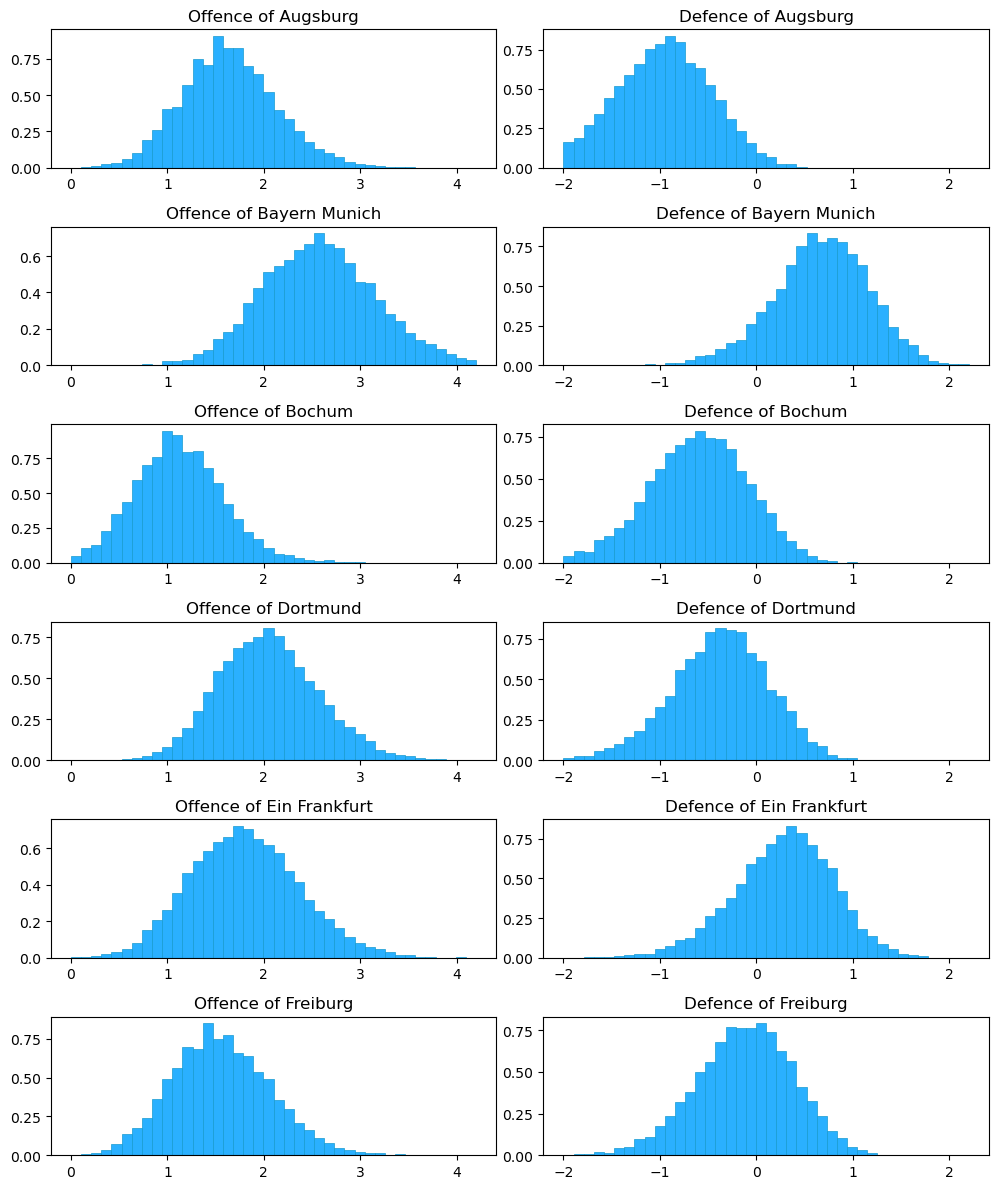

In [66]:
show_teams = 5
# show_teams = nb_teams

bins = 40
fig, axes = plt.subplots(
    nrows=show_teams + 1, ncols=2, figsize=(10, (show_teams + 1) * 2)
)

for x, (t, i) in enumerate(team_indices.items()):
    title = "Offence of " + t
    axes[i, 0].set_title(title)
    axes[i, 0].hist(offence[i], bins=bins, range=(0, 4.2), **plot_hist_param)

    axes[i, 1].hist(defence[i], bins=bins, range=(-2.0, 2.2), **plot_hist_param)
    title = "Defence of " + t
    axes[i, 1].set_title(title)
    if x >= show_teams:
        break

# fig.suptitle("Offence and defence distribution of the clubs.")
fig.subplots_adjust(hspace=0.5)
fig.tight_layout()
# plt.savefig('pics/figure_7.png')

In [67]:
# pm.predictions_to_inference_data
with model1:
    samples = pm.sample_posterior_predictive(trace)

Sampling: [away_goals, home_goals]


Output()

In [68]:
def get_diffs(
    team_1, team_2, offence, defence
):  # toDO: offenc defence add in function from model1
    diff_ij = offence[team_1] - defence[team_2]
    diff_ji = offence[team_2] - defence[team_1]
    return diff_ij, diff_ji

In [69]:
def get_probs_winner(teamIndex1, teamIndex2):
    diff_ij, diff_ji = get_diffs(teamIndex1, teamIndex2, offence, defence)
    diff_ij[diff_ij < min_mu] = min_mu
    diff_ji[diff_ji < min_mu] = min_mu

    goals_of_team_1 = np.array([np.random.poisson(r) for r in diff_ij])
    goals_of_team_2 = np.array([np.random.poisson(r) for r in diff_ji])

    team1_wins = goals_of_team_1 > goals_of_team_2
    team2_wins = goals_of_team_1 < goals_of_team_2
    tie = goals_of_team_1 == goals_of_team_2

    p1 = team1_wins.mean()
    p2 = team2_wins.mean()
    tie = tie.mean()
    np.testing.assert_almost_equal(1.0, p1 + tie + p2)
    return tie, p1, p2

In [70]:
def get_goal_distribution(diff, max_goals=20):
    poisson_goals = np.zeros(max_goals)
    k = np.arange(0, max_goals)
    for lambda_ in diff:
        lambda_ = max(low, lambda_)
        poisson_goals += scipy.stats.poisson.pmf(k, lambda_)
    poisson_goals = poisson_goals / poisson_goals.sum()
    return poisson_goals

In [71]:
def plot_goal_diffs(team_1, team_2, offence, defence, max_goals=8):
    diff_ij, diff_ji = get_diffs(team_1, team_2, offence, defence)
    poisson_goals_1 = get_goal_distribution(diff_ij, max_goals)
    poisson_goals_2 = get_goal_distribution(diff_ji, max_goals)
    # Create the figure and axes objects, specify the size and the dots per inches
    fig, ax = plt.subplots(figsize=(6, 4), dpi=96)

    # Plot bars
    x = np.arange(0, max_goals)
    width = 0.4
    bar1 = ax.bar(
        x - width / 2,
        poisson_goals_1,
        width=width,
        alpha=0.9,
        label="Tore von " + teams[team_1],
    )  # Add in title and subtitle
    bar2 = ax.bar(
        x + width / 2,
        poisson_goals_2,
        width=width,
        alpha=0.9,
        label="Tore von " + teams[team_2],
    )  # Add in title and subtitle
    ax.set_xticks(x, x)
    ax.text(
        x=0.12,
        y=0.93,
        s="Torvorhersage",
        transform=fig.transFigure,
        ha="left",
        fontsize=10,
        weight="bold",
        alpha=1.0,
    )
    ax.text(
        x=0.12,
        y=0.90,
        s=teams[team_1] + " gegen " + teams[team_2],
        transform=fig.transFigure,
        ha="left",
        fontsize=8,
        alpha=1.0,
    )
    ax.legend()
    # figure for book
    # plt.savefig('pics/figure_8    defence_dim_0  int64 1 (8000,).png')

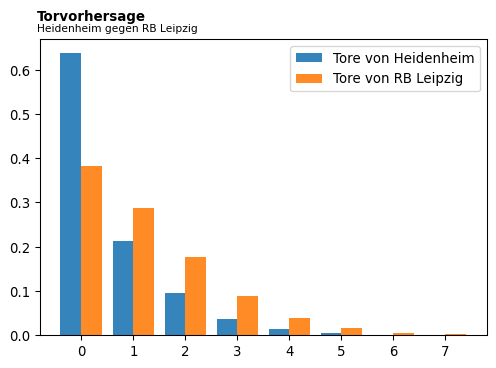

In [72]:
teamIndex1, teamIndex2 = 6, 12
plot_goal_diffs(teamIndex1, teamIndex2, offence, defence)

In [73]:
get_probs_winner(teamIndex1, teamIndex2)

(0.322875, 0.197, 0.480125)

# Model 2

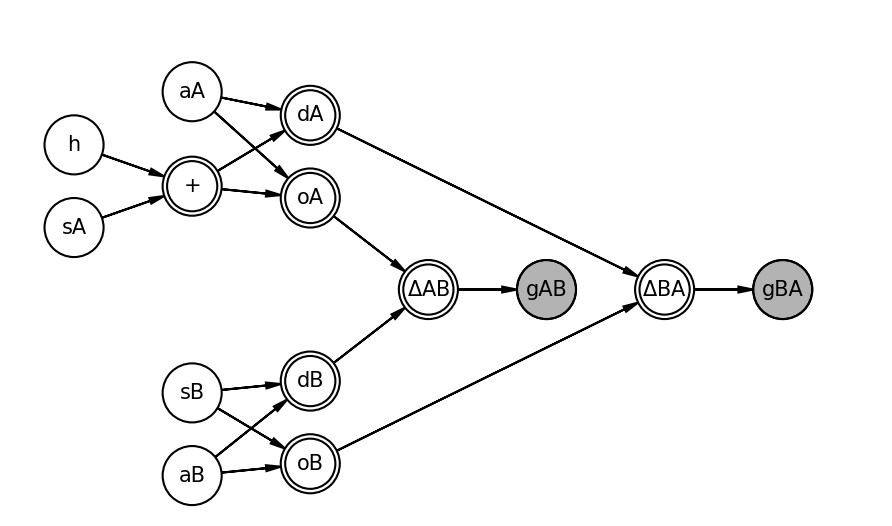

In [ ]:
import daft

y_shift = 0.75


def plot_model(home=False, result=False):
    if home:
        pgm = daft.PGM(
            [7.3, 4.2],
            grid_unit=2.0,
            node_unit=1.0,
            origin=[0.0, 0.0],
            aspect=1.0,
            dpi=150,
        )

        pgm.add_node(daft.Node("sA_", r"sA", 0.5, 1.65 + y_shift))
        pgm.add_node(daft.Node("h", r"h", 0.5, 2.35 + y_shift))
        pgm.add_node(daft.Node("sA", r"+", 1.5, 2 + y_shift))
        pgm.add_node(daft.Node("none_+", "", 1.5, 2 + y_shift, scale=0.85, aspect=1))
        pgm.add_edge("sA_", "sA")
        pgm.add_edge("h", "sA")
    else:
        pgm = daft.PGM(
            [6.3, 4.2],
            grid_unit=2.0,
            node_unit=1.0,
            origin=[1.0, 0.0],
            aspect=1.0,
            dpi=150,
        )
        pgm.add_node(daft.Node("sA", r"sA", 1.5, 2.8))

    pgm.add_node(daft.Node("aA", r"aA", 1.5, 2.8 + y_shift))

    pgm.add_node(daft.Node("aB", r"aB", 1.5, 0.3))
    pgm.add_node(daft.Node("sB", r"sB", 1.5, 1.0))

    # pgm.add_node(daft.Node("Delta", r"$\Delta_{ij}$", 2.5, 1))
    pgm.add_node(daft.Node("oA", r"oA", 2.5, 1.9 + y_shift))
    pgm.add_node(daft.Node("none_oA", "", 2.5, 1.9 + y_shift, scale=0.85, aspect=1))
    pgm.add_node(daft.Node("dA", r"dA", 2.5, 2.6 + y_shift))
    pgm.add_node(daft.Node("none_dA", "", 2.5, 2.6 + y_shift, scale=0.85, aspect=1))

    pgm.add_node(daft.Node("dB", r"dB", 2.5, 1.1))
    pgm.add_node(daft.Node("none_dB", "", 2.5, 1.1, scale=0.85, aspect=1))

    pgm.add_node(daft.Node("oB", r"oB", 2.5, 0.4))
    pgm.add_node(daft.Node("none_oB", "", 2.5, 0.4, scale=0.85, aspect=1))

    pgm.add_node(daft.Node("diffAB", r"$\Delta$AB", 3.5, 1.5 + y_shift / 2))
    pgm.add_node(daft.Node("none_AB", "", 3.5, 1.5 + y_shift / 2, scale=0.85, aspect=1))

    pgm.add_node(daft.Node("diffBA", r"$\Delta$BA", 5.5, 1.5 + y_shift / 2))
    pgm.add_node(daft.Node("none_BA", "", 5.5, 1.5 + y_shift / 2, scale=0.85, aspect=1))

    pgm.add_node(daft.Node("gAB", r"gAB", 4.5, 1.5 + y_shift / 2, observed=True))
    pgm.add_node(daft.Node("gBA", r"gBA", 6.5, 1.5 + y_shift / 2, observed=True))

    # Add in the edges.
    pgm.add_edge("sA", "oA")
    pgm.add_edge("aA", "oA")
    pgm.add_edge("sA", "dA")
    pgm.add_edge("aA", "dA")

    pgm.add_edge("sB", "oB")
    pgm.add_edge("aB", "oB")
    pgm.add_edge("sB", "dB")
    pgm.add_edge("aB", "dB")

    pgm.add_edge("oA", "diffAB")
    pgm.add_edge("dB", "diffAB")
    pgm.add_edge("diffAB", "gAB")
    pgm.add_edge("oB", "diffBA")
    pgm.add_edge("dA", "diffBA")
    pgm.add_edge("diffBA", "gBA")

    if result:
        pgm.add_node(daft.Node("w", r"$\bf{w}$", 1.5, 1.5 + y_shift / 2))
        pgm.add_node(
            daft.Node("result", r"result", 2.5, 1.5 + y_shift / 2, observed=True)
        )
        pgm.add_edge("w", "result")
        pgm.add_edge("sA", "result")
        pgm.add_edge("sB", "result")

    # And plates.
    pgm.render()


# plot_model(True, True)
plot_model(True, False)
# plot_model(False, False)

In [ ]:
model2 = pm.Model()
with model2:
    score = pm.Normal("score", tau=1.0, mu=0.0, shape=nb_teams)
    offence_defence_diff = pm.Normal(
        "offence_defence_diff", tau=1.0, mu=average_goals / 2.0, shape=nb_teams
    )

    home_advantage = pm.Normal("home_advantage", tau=10.0, mu=0.0)

    # softmax regression weights for winner predicton:
    weights = pm.Normal("weights", mu=(0.0, 0.25, -0.25), tau=100.0, shape=(3))

    score_home = score[home_id] + home_advantage
    offence_home = score_home + offence_defence_diff[home_id]
    defence_home = score[home_id] - offence_defence_diff[home_id]
    offence_away = score[away_id] + offence_defence_diff[away_id]
    defence_away = score[away_id] - offence_defence_diff[away_id]

    mu_home = pm.math.exp(offence_home - defence_away)
    mu_away = pm.math.exp(offence_away - defence_home)
    home_value = pm.math.switch(mu_home < min_mu, min_mu, mu_home)
    away_value = pm.math.switch(mu_away < min_mu, min_mu, mu_away)

    pm.Poisson("home_goals", observed=home_goals, mu=mu_home)
    pm.Poisson("away_goals", observed=away_goals, mu=mu_away)

    home_away_score_diff = score_home - score[away_id]
    home_away_score_diff = home_away_score_diff.reshape((-1, 1)).repeat(3, axis=1)

    pred = pm.math.exp(home_away_score_diff * weights)
    pred = (pred.T / pm.math.sum(pred, axis=1)).T
    pm.Categorical("toto", p=pred, observed=toto)

In [ ]:
nb_samples = 10000
### tune adds additional number of samples.
### after sampling these additional samples get discarded
### as the very first samples are very inaccurate
tune = nb_samples // 10

with model2:
    trace_ = pm.sample(draws=nb_samples, tune=tune)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [score, offence_defence_diff, home_advantage, weights]


In [ ]:
posterior = trace_.posterior.stack(sample=["chain", "draw"])
weights = posterior["weights"]
offence_defence_diff = posterior["offence_defence_diff"]
score = posterior["score"]
home_advantage = posterior["home_advantage"]

In [ ]:
bins = 40
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 5))

for i in range(3):
    axes[i].set_title("weight " + str(i))
    axes[i].hist(weights.data[i, :], bins=bins, range=(-1, 1), **plot_hist_param)

    # fig.suptitle("Offence and defence distribution of the clubs.")
fig.subplots_adjust(hspace=0.5)
fig.tight_layout()

In [ ]:
### mean of offence strength
print("Mean score and offence_defence_diff:")

team_score = dict()
for t in teams:
    i = team_indices[t]
    print(t, "\t", score[i].mean().values, offence_defence_diff[i].mean().values)
    team_score[t] = score[i].mean().values

In [ ]:
from collections import OrderedDict

d_descending = OrderedDict(
    sorted(team_score.items(), key=lambda kv: kv[1], reverse=True)
)
score_list = {team: float(score) for team, score in d_descending.items()}
score_list

In [ ]:
tabelle = [
    "Bayern Munich",
    "Dortmund",
    "RB Leipzig",
    "Union Berlin",
    "Freiburg",
    "Leverkusen",
    "Ein Frankfurt",
    "Wolfsburg",
    "Mainz",
    "M'gladbach",
    "FC Koln",
    "Hoffenheim",
    "Werder Bremen",
    "Bochum",
    "Augsburg",
    "Stuttgart",
    "Schalke 04",
    "Hertha",
]
tabelle_place = {team: (i + 1) for i, team in enumerate(tabelle)}
# tabelle_place[tabelle[0]]
tabelle_scores = [
    [team, scores, tabelle_place[team]] for team, scores in score_list.items()
]
tabelle_scores

In [ ]:
# from tabulate import tabulate
# col_names = ["Team", "Spielstärke", "Tabellenplatz"]
# print(tabulate(tabelle_scores, headers=col_names, tablefmt="pretty"))

In [ ]:
print("Durchschnittlicher Heimvorteil", home_advantage.mean())

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
title = "Heimvorteil"
plt.title(title)
plt.hist(home_advantage, bins=bins, range=(-0.5, 1), **plot_hist_param)

In [ ]:
bins = 40
MAX_TEAMS = 4  # nb_teams

fig, axes = plt.subplots(nrows=MAX_TEAMS, ncols=2, figsize=(10, 3 * MAX_TEAMS))

for t, i in team_indices.items():
    title = "Spielstärke " + t
    axes[i, 0].set_title(title)
    axes[i, 0].hist(score[i], bins=bins, range=(-2, 3), **plot_hist_param)

    axes[i, 1].hist(
        offence_defence_diff[i], bins=bins, range=(-2.0, 2.2), **plot_hist_param
    )

    title = "Offensive-Devensiv-Abweichung " + t
    axes[i, 1].set_title(title)

    if i == MAX_TEAMS - 1:
        break

# fig.suptitle("Score and offence-defence difference of the teams.")
fig.subplots_adjust(hspace=0.5)
fig.tight_layout()

In [ ]:
def get_diffs_(ta, th):
    add_h = offence_defence_diff[ta]
    home_offence = score[ta] + add_h
    home_defence = score[ta] - add_h

    add_a = offence_defence_diff[th]
    away_offence = score[th] + add_a
    away_defence = score[th] - add_a

    return home_offence - away_defence, away_offence - home_defence

In [ ]:
diff_ij_, diff_ji_ = get_diffs_(1, 17)
poisson_goals_1_a = get_goal_distribution(diff_ij_)
poisson_goals_2_a = get_goal_distribution(diff_ji_)

In [4]:
import numpy as np

np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])